# Location-Based Consumer Preference Inference

Notebook used for inspection of the GeoLife dataset, retrieved from  
https://www.microsoft.com/en-us/research/project/geolife-building-social-networks-using-human-location-history/#!downloads  
  
The description of the data can be found in the path `<PATH TO GeoLife>`/Geolife Trajectories 1.3/User Guide-1.3.pdf  

In [2]:
from math import sqrt, cos, sin, pi, radians, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

import os.path

import sqlite3

from datetime import *
import datetime as dt

from geopy.distance import lonlat, distance, vincenty, geodesic

import pandas as pd

import folium
from folium import plugins
#from sklearn.cluster import OPTICS # not officially included at this stage
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import numpy as np

import random;

#from sklearn.cluster import 

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.utils import read_sample, timedcall
from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES

In [3]:
def template_clustering(sample, eps, minpts, amount_clusters = None, visualize = True, ccore = False):
    #sample = read_sample(path_sample);
    optics_instance = optics(sample, eps, minpts, amount_clusters, ccore);
    (ticks, _) = timedcall(optics_instance.process);
    
    #print("Sample: ", sample, "\t\tExecution time: ", ticks, "\n");
    
    if (visualize is True):
        clusters = optics_instance.get_clusters();
        noise = optics_instance.get_noise();
    
        visualizer = cluster_visualizer();
        visualizer.append_clusters(clusters, sample);
        visualizer.append_cluster(noise, sample, marker = 'x');
        visualizer.show();
    
        ordering = optics_instance.get_ordering();
        analyser = ordering_analyser(ordering);
        
        ordering_visualizer.show_ordering_diagram(analyser, amount_clusters);    
        clust = [item for sublist in clusters for item in sublist]
        encoding = optics_instance.get_cluster_encoding()
        #print("clusters = ", clust, " || # idx = ", len(clust))
        #print("ordering = ", ordering)
    return clusters, clust, ordering, encoding

In [4]:
#### Retrieve data, based on SELECTION from (SQLite) DB stored in DBFILE, located in PATH
def sqlite_2_pd_df(selection, path, dbfile, db):    
    os.chdir(path)
    con=sqlite3.connect(dbfile)
    con.text_factory = sqlite3.OptimizedUnicode
    query = con.execute("SELECT " + selection + " From " + db)
    cols = [column[0] for column in query.description]
    df= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    return df.sort_values(['usrID', 'trkID', 'time str'], ascending=[True, True, True])

In [5]:
#### Test example
#### The file GeoLifeDBMINI.db holds a SQLite DB with the 
workdir = '/home/patrickm/projects/GeoLife/'
DBfile  = 'GeoLifeDBMINI.db'

#### Function calculating length of a trajectory
def time_list(time):
    ln = len(time)
    time.sort()
    return (dt.datetime.strptime( time[len(time)-1], '%H:%M:%S') - dt.datetime.strptime(time[0], '%H:%M:%S')).total_seconds()

def tracklengthGEO(lat, long, alt=None):
    ln = len(lat)
    trkseg = [ geodesic((lat[i+1], long[i+1], alt[i+1]), (lat[i], long[i], alt[i] )).miles for i in range(ln-1) ]
    return sum(trkseg)

def DistGEO(coord1, coord2):
    lat1, long1 = coord1
    lat2, long2 = coord2
    return geodesic((lat1, long1), (lat2, long2 )).m

def DistSeries(lat, long):
    ln = len(lat)
    d_i = [ (i, geodesic((lat[i+1], long[i+1], alt[i+1]), (lat[i], long[i], alt[i] )).m) for i in range(ln-1) ]
    d_i = d_i + [None]
    return d_i
    
#lat = [1., 1., 1.3, 1.4, 1.6, 1.6, 1.6, 1.7, 1.8, 1.8, 1.8, 1.9]
#lng = [2., 2., 2.3, 2.4, 1.6, 1.6, 1.6, 1.7, 2.8, 2.8, 2.8, 2.9]

#DS = DistSeries(lat, lng)

#print("lat[-1] = ", lat[-1])
#print("Dist list : ", DS, " len(Dist list) = ", len(DS), " || len(lat,lng) = ", len(lat))

## test
time1 = '22:29:01'
time2 = '23:30:02'
time = [time1, time2]
print (time_list(time))

3661.0


In [6]:
#### Create dataframe from SQLite DB
df = sqlite_2_pd_df("*", workdir, DBfile, "GeoLifeDBMINI")
#df.sort_values(['usrID', 'trkID', 'time str'], ascending=[True, True, True])

In [7]:
# Pandas gymnastics

tmp = df.copy(deep=True)
tmp.reset_index()
tmp.set_index(['usrID','trkID'], inplace = True)
tmp = tmp.groupby(['usrID', 'trkID']).size().to_frame('no of markers')
print(tmp.head(100))
print(tmp.reset_index())


tmp2 = df.copy(deep=True)
tmp2.reset_index()
#print (tmp2.loc[tmp2['usrID']==2].head())

                      no of markers
usrID trkID                        
0     20081023025304            908
      20081024020959            244
      20081026134407            745
      20081027115449             50
      20081028003826           1477
      20081029092138             21
      20081029093038            182
      20081103101336              7
      20081103232153           2231
      20081110013637            272
      20081111001704           1477
      20081112023003            681
      20081112091400             27
      20081113034608            494
      20081114015255            337
      20081114101436            305
      20081115010133            281
      20081116085532             12
      20081117051133             81
      20081117155223            314
      20081118095005             32
      20081118095400            254
      20081118162008              7
      20081119012806             81
      20081119112035            419
      20081120035736        

,index,Lat,Long,Alt,no days,date str,time str,usrID,trkID
0,67366,39.984702,116.318417,492,39744.120185,2008-10-23,02:53:04,0,20081023025304
1,67367,39.984683,116.318450,492,39744.120255,2008-10-23,02:53:10,0,20081023025304
2,67368,39.984686,116.318417,492,39744.120313,2008-10-23,02:53:15,0,20081023025304
3,67369,39.984688,116.318385,492,39744.120370,2008-10-23,02:53:20,0,20081023025304
4,67370,39.984655,116.318263,492,39744.120428,2008-10-23,02:53:25,0,20081023025304
5,67371,39.984611,116.318026,493,39744.120486,2008-10-23,02:53:30,0,20081023025304
6,67372,39.984608,116.317761,493,39744.120544,2008-10-23,02:53:35,0,20081023025304
7,67373,39.984563,116.317517,496,39744.120602,2008-10-23,02:53:40,0,20081023025304
8,67374,39.984539,116.317294,500,39744.120660,2008-10-23,02:53:45,0,20081023025304
9,67375,39.984606,116.317065,505,39744.120718,2008-10-23,02:53:50,0,20081023025304


In [8]:
usr = 0

# tracks
mrks = df.loc[df['usrID'] == usr].sort_values(by=['trkID', 'time str'], ascending=True)
print(mrks)

count = 0
for i in mrks['trkID'].unique():
    lat = []
    long= []
    alt = []
    time= []
    count += 1
    
    lat = [lt for lt in mrks.loc[mrks['trkID']==str(i)]['Lat'] ]
    long = [lng for lng in mrks.loc[mrks['trkID']==str(i)]['Long'] ]
    alt = [al for al in mrks.loc[mrks['trkID']==str(i)]['Alt'] ]
    time = [tm for tm in mrks.loc[mrks['trkID']==str(i)]['time str'] ]#.apply(lambda x: dt.strptime(x , '%H:%M:%S').dt.total_seconds() ) ] 
    #print(lat)
    if count%20 == 0: print ("Trajectory ", i, " is ", tracklengthGEO(lat,long,alt), " miles long,  time spent :", time_list(time), " sec,   crude avg. speed : ", tracklengthGEO(lat,long,alt)/time_list(time)*3600., " mph")


#print (mrks.loc[mrks['time str'] == '02:53:10'].head(20))

             Lat        Long  Alt       no days    date str  time str  usrID  \
67366  39.984702  116.318417  492  39744.120185  2008-10-23  02:53:04      0   
67367  39.984683  116.318450  492  39744.120255  2008-10-23  02:53:10      0   
67368  39.984686  116.318417  492  39744.120313  2008-10-23  02:53:15      0   
67369  39.984688  116.318385  492  39744.120370  2008-10-23  02:53:20      0   
67370  39.984655  116.318263  492  39744.120428  2008-10-23  02:53:25      0   
67371  39.984611  116.318026  493  39744.120486  2008-10-23  02:53:30      0   
67372  39.984608  116.317761  493  39744.120544  2008-10-23  02:53:35      0   
67373  39.984563  116.317517  496  39744.120602  2008-10-23  02:53:40      0   
67374  39.984539  116.317294  500  39744.120660  2008-10-23  02:53:45      0   
67375  39.984606  116.317065  505  39744.120718  2008-10-23  02:53:50      0   
67376  39.984568  116.316911  510  39744.120775  2008-10-23  02:53:55      0   
67377  39.984586  116.316716  515  39744

## Stay Points location
  
  In the following we try out an algorithm used to find so-called *stay points*. Currently it appears ugly, and I am hoping that a more elegant and efficient algorithm will be found.  
  The algorithm works as follows:
  * For each user $u_i$, for each trajectory $traj_{u_i, j}$: run a clustering algorithm (SPcandidates) among the time stamps pertaining to each set of coordinates. This creates a list of time stamps $\{ t_m, \ldots, t_n \}$ where $| t_i - t_j | \geq T_{\mathrm{threshold}}$  (20min in this particular case), for $t_i, t_j \in \{ t_m, \ldots, t_n \}$.
  * Use the same type of clustering algorithm (clust) to see if the coordinates corresponding to the aforementioned timestamps fulfill the criteria $\mathrm{dist}\left ( (\mathrm{lat}_i, \mathrm{long}_i), (\mathrm{lat}_j, \mathrm{long}_j) \right) \leq D_{\mathrm{threshold}}$ (200m in this particular case)
  * If the time stamp and corresponding coordinates fulfull the abovemenentioned criteria then a *stay point* is calculated

In [109]:
def SP_clust(coords,times):
    assert(len(coords) == len(times))
    dist = [0.]
    dT = [0.]
    clust = []
    SPcoords = []
    SPtimes = []
    Tthres = 20. * 60. # Time threshold (20 min.) 
    Dthres = 200. # Distance threshold (200 m)    

    for i in range(len(coords)-1):
        d = DistGEO(coords[i], coords[i+1])
        dist.append(d)
        dt = time_list([times[i], times[i+1]])
        dT.append(dt)        
    
    assert(len(dT) == len(times))
    assert(len(dist) == len(times))

    sumT = 0.
    sumd = 0.
    old_idx = 0

    for i in range(len(dT)-1):
        sumT = sum(dT[old_idx:i+1])
        sumT_ref = sum(dT[old_idx:i+2])
        sumd = sum(dist[old_idx:i+1])
        sumd_ref = sum(dist[old_idx:i+2])
        if (sumT < Tthres): 
            if sumd <= Dthres: # continue
                pass
            else: # brak, not a stay point
                old_idx = i
        else: # more than Tthres accumulated time
            if sumd <= Dthres: # still within stay point radius, keep recording
                if sumd_ref > Dthres: #record stay point, right at the boundary
                    #SP.append( ((sum([coord[0] for coord in coords[old_idx:i+1]])/float(len(coords[old_idx:i+1])), sum([coord[1] for coord in coords[old_idx: i+1]])/float(len(coords[old_idx: i+1])) ), [times[old_idx],times[i]] ) )
                    SPcoords.append((sum([coord[0] for coord in coords[old_idx:i+1]])/float(len(coords[old_idx:i+1])), sum([coord[1] for coord in coords[old_idx: i+1]])/float(len(coords[old_idx: i+1])) )  )
                    SPtimes.append([times[old_idx],times[i]])
                    old_idx = i+1
                    #sumT = 0.
                    #sumd = 0.
                else: # more points can fit in the area of the stay point
                    pass
                
    return SPcoords, SPtimes # return lists = [(coords)], [[arvT, levT]]
        
#dict(enumerate(TimeClust(time), 1))

Tt = 20 * 60. # threshold in seconds
Dt = 200. # Distance threshold in meters

SPs = []
SP  = []
SPc = [] 
SPt = []
LocHistTmp = {}
LocHist = {}
#for usr in df['usrID'].unique():
for usr in [0,1,2,3]:
    SPcoords = []  # Stay point coordinates for a given user
    SPtimes  = []  # Corresponding  arrival and leaving times of a stay point
    mrks = df.loc[df['usrID'] == usr]#.sort_values(by=['trkID', 'time str'], ascending=True)    

    for i in mrks['trkID'].unique():
        count += 1
        lats  = [lt for lt in mrks.loc[(mrks['trkID']==str(i) )]['Lat'] ]
        longs = [lng for lng in mrks.loc[(mrks['trkID']==str(i) ) ]['Long'] ]
        times = [tm for tm in mrks.loc[(mrks['trkID']==str(i) ) ]['time str'] ]
        coords = list(zip(lats,longs))
        
        SPcoords, SPtimes = SP_clust(coords, times)
        if len(SPcoords) > 0: 
            SPc.append(SPcoords)
            SPt.append(SPtimes)
    LocHist.update( { usr: (SPc, SPt) } )
    print("User LocHist : ", LocHist)
    
StayPoints = dict(enumerate(SPs, 0))
print("~~~ FINAL ~~~")
print("Stay Points : ", LocHist)

User LocHist :  {0: ([[(40.0116045802469, 116.2968199259259)], [(39.999914000000004, 116.3244645), (40.01004858333334, 116.32233608333333), (40.00741052631578, 116.3199819473684)], [(39.999886687499995, 116.32438262500001)], [(40.00881339130435, 116.3209731304348)], [(39.99660528409092, 116.32202282954546), (39.99987786666667, 116.32742286666665)], [(40.000032, 116.32734288235295), (40.0066046153846, 116.31693942307695), (40.007259375, 116.32061562499997)], [(39.99996017777778, 116.32722713333337)], [(40.00981780645159, 116.31508861290322), (40.00975689595376, 116.31514275144502), (40.009728560344826, 116.31517903448271), (40.00992782142858, 116.31535503571429)], [(40.07959831034482, 116.58792748275863)], [(39.99988477272727, 116.3272308181818)], [(39.76273445454545, 116.29731822727275), (39.762993571428574, 116.29741457142858), (39.99996321428572, 116.32739207142858)], [(39.99505241666667, 116.32103516666668), (39.99995275, 116.32720950000001), (39.762720818181805, 116.29730809090911)

User LocHist :  {0: ([[(40.0116045802469, 116.2968199259259)], [(39.999914000000004, 116.3244645), (40.01004858333334, 116.32233608333333), (40.00741052631578, 116.3199819473684)], [(39.999886687499995, 116.32438262500001)], [(40.00881339130435, 116.3209731304348)], [(39.99660528409092, 116.32202282954546), (39.99987786666667, 116.32742286666665)], [(40.000032, 116.32734288235295), (40.0066046153846, 116.31693942307695), (40.007259375, 116.32061562499997)], [(39.99996017777778, 116.32722713333337)], [(40.00981780645159, 116.31508861290322), (40.00975689595376, 116.31514275144502), (40.009728560344826, 116.31517903448271), (40.00992782142858, 116.31535503571429)], [(40.07959831034482, 116.58792748275863)], [(39.99988477272727, 116.3272308181818)], [(39.76273445454545, 116.29731822727275), (39.762993571428574, 116.29741457142858), (39.99996321428572, 116.32739207142858)], [(39.99505241666667, 116.32103516666668), (39.99995275, 116.32720950000001), (39.762720818181805, 116.29730809090911)

User LocHist :  {0: ([[(40.0116045802469, 116.2968199259259)], [(39.999914000000004, 116.3244645), (40.01004858333334, 116.32233608333333), (40.00741052631578, 116.3199819473684)], [(39.999886687499995, 116.32438262500001)], [(40.00881339130435, 116.3209731304348)], [(39.99660528409092, 116.32202282954546), (39.99987786666667, 116.32742286666665)], [(40.000032, 116.32734288235295), (40.0066046153846, 116.31693942307695), (40.007259375, 116.32061562499997)], [(39.99996017777778, 116.32722713333337)], [(40.00981780645159, 116.31508861290322), (40.00975689595376, 116.31514275144502), (40.009728560344826, 116.31517903448271), (40.00992782142858, 116.31535503571429)], [(40.07959831034482, 116.58792748275863)], [(39.99988477272727, 116.3272308181818)], [(39.76273445454545, 116.29731822727275), (39.762993571428574, 116.29741457142858), (39.99996321428572, 116.32739207142858)], [(39.99505241666667, 116.32103516666668), (39.99995275, 116.32720950000001), (39.762720818181805, 116.29730809090911)

In [117]:
#print(LocHist[0][0][0])
SPall = []
for usr in [0,1,2,3]:
    for coordlist in LocHist[usr][0]:
        #print ("coordlist = ", coordlist)
        #for coord in coordlist:
        #    print("coord = ", coord)
        SPall.append(coordlist )
SPall = [crd for coord in SPall for crd in coord]
#SPall = [ sp for coordlst in LocHist[usr][0] for usr in [0,1,2,3]]
SPalldict = {i:SPall[i] for i in range(len(SPall))}
print("SPalldict : ", SPalldict)
print("len SPalldict : ", len(SPalldict))
print("~~~")
print("~~~")
crds = [crd for coord in list(SPalldict.values()) for crd in coord]
paircrds = [coord for coord in list(SPalldict.values())]
print("crds = ", crds)
print("pairs of crds = ", paircrds)
print("len crds = ", len(crds) )

SPalldict :  {0: (40.0116045802469, 116.2968199259259), 1: (39.999914000000004, 116.3244645), 2: (40.01004858333334, 116.32233608333333), 3: (40.00741052631578, 116.3199819473684), 4: (39.999886687499995, 116.32438262500001), 5: (40.00881339130435, 116.3209731304348), 6: (39.99660528409092, 116.32202282954546), 7: (39.99987786666667, 116.32742286666665), 8: (40.000032, 116.32734288235295), 9: (40.0066046153846, 116.31693942307695), 10: (40.007259375, 116.32061562499997), 11: (39.99996017777778, 116.32722713333337), 12: (40.00981780645159, 116.31508861290322), 13: (40.00975689595376, 116.31514275144502), 14: (40.009728560344826, 116.31517903448271), 15: (40.00992782142858, 116.31535503571429), 16: (40.07959831034482, 116.58792748275863), 17: (39.99988477272727, 116.3272308181818), 18: (39.76273445454545, 116.29731822727275), 19: (39.762993571428574, 116.29741457142858), 20: (39.99996321428572, 116.32739207142858), 21: (39.99505241666667, 116.32103516666668), 22: (39.99995275, 116.327209

## Experimenting with the OPTICS clustering algorithm

In [112]:
#Keep track of indexing at each level
def clust_idx_tracker(clusters):
    clustdict = {}
    for cluster in clusters:
        clustdict.update( {clusters.index(cluster) : { i : cluster[i] for i in range(len(cluster)) }  } )
    return clustdict

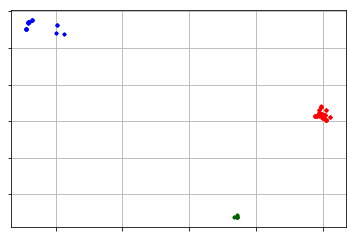

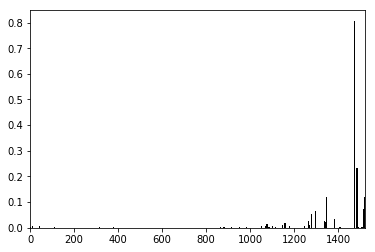

{0: 0, 1: 1143, 2: 762, 3: 381, 4: 1445, 5: 1180, 6: 1064, 7: 799, 8: 683, 9: 418, 10: 302, 11: 37, 12: 1273, 13: 892, 14: 511, 15: 130, 16: 1270, 17: 889, 18: 508, 19: 127, 20: 1266, 21: 885, 22: 504, 23: 123, 24: 1265, 25: 884, 26: 503, 27: 122, 28: 1278, 29: 897, 30: 516, 31: 135, 32: 1279, 33: 898, 34: 517, 35: 136, 36: 1274, 37: 893, 38: 512, 39: 131, 40: 1276, 41: 895, 42: 514, 43: 133, 44: 1491, 45: 1226, 46: 1110, 47: 845, 48: 729, 49: 464, 50: 348, 51: 83, 52: 1443, 53: 1178, 54: 1062, 55: 797, 56: 681, 57: 416, 58: 300, 59: 35, 60: 1420, 61: 1155, 62: 1039, 63: 774, 64: 658, 65: 393, 66: 277, 67: 12, 68: 1421, 69: 1156, 70: 1040, 71: 775, 72: 659, 73: 394, 74: 278, 75: 13, 76: 1422, 77: 1157, 78: 1041, 79: 776, 80: 660, 81: 395, 82: 279, 83: 14, 84: 1423, 85: 1158, 86: 1042, 87: 777, 88: 661, 89: 396, 90: 280, 91: 15, 92: 1417, 93: 1152, 94: 1036, 95: 771, 96: 655, 97: 390, 98: 274, 99: 9, 100: 1367, 101: 986, 102: 605, 103: 224, 104: 1511, 105: 1246, 106: 1130, 107: 865, 108

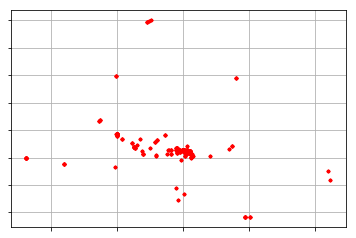

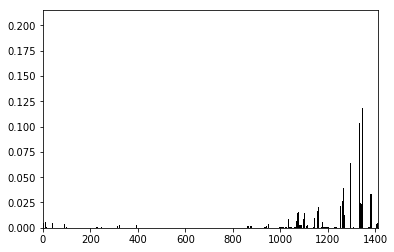

TMP clust :  [[0, 3, 2, 1, 11, 10, 9, 8, 7, 6, 5, 4, 15, 14, 13, 12, 19, 18, 17, 16, 23, 22, 21, 20, 27, 26, 25, 24, 31, 30, 29, 28, 35, 34, 33, 32, 39, 38, 37, 36, 43, 42, 41, 40, 51, 50, 49, 48, 47, 46, 45, 44, 59, 58, 57, 56, 55, 54, 53, 52, 67, 66, 65, 64, 63, 62, 61, 60, 75, 74, 73, 72, 71, 70, 69, 68, 83, 82, 81, 80, 79, 78, 77, 76, 91, 90, 89, 88, 87, 86, 85, 84, 99, 98, 97, 96, 95, 94, 93, 92, 103, 102, 101, 100, 111, 110, 109, 108, 107, 106, 105, 104, 119, 118, 117, 116, 115, 114, 113, 112, 127, 126, 125, 124, 123, 122, 121, 120, 135, 134, 133, 132, 131, 130, 129, 128, 139, 138, 137, 136, 143, 142, 141, 140, 147, 146, 145, 144, 151, 150, 149, 148, 155, 154, 153, 152, 163, 162, 161, 160, 159, 158, 157, 156, 171, 170, 169, 168, 167, 166, 165, 164, 179, 178, 177, 176, 175, 174, 173, 172, 187, 186, 185, 184, 183, 182, 181, 180, 195, 194, 193, 192, 191, 190, 189, 188, 199, 198, 197, 196, 207, 206, 205, 204, 203, 202, 201, 200, 215, 214, 213, 212, 211, 210, 209, 208, 223, 222, 221, 

TypeError: object of type 'int' has no len()

In [116]:
eps = 5.2
minpts = 5
SPlst = [crd for coord in list(SPalldict.values()) for crd in coord]
clusters, clust, order, encoding = template_clustering(list(SPalldict.values()), eps, minpts)
#clusters, clust, order, encoding = template_clustering(SPlst, eps, minpts)
#clust.sort()
#print(clust, len(clust), dict(enumerate(clust,0)))
print(dict(enumerate(clust,0)))
print(clusters)
print("######")
print("clust idx tracking : ", clust_idx_tracker(clusters))
print("######")
print("enc : ", encoding)
print("SPalldict : ", SPalldict)

#for minpts in [3,5,7,9,11,15,20]:
#    for eps in [0.05, 0.1, 0.15, 0.20, 0.25]:
#        template_clustering(SPs, eps, minpts)
for cluster in clusters:
    SPtmp = [SPalldict[idx] for idx in cluster]
    clusters_tmp, clust_tmp, order_tmp, encoding_tmp = template_clustering(SPtmp, eps, minpts)
    print("TMP clust : ", clusters_tmp)
    for cluster in clusters_tmp:
        print("~~~~~~ LVL 2 ~~~~~~")
        clusters_tmp2, clust_tmp2, order_tmp2, encoding_tmp2 = template_clustering(cluster, eps, minpts)

## Playing with Folium
  
  Here we play with the folium package for python and plot markers corresponding to trajectory files.

In [ ]:
BEIJING_COORDINATES = ( 39.9062170, 116.3912757 )
# for speed purposes
MAX_RECORDS = 1000
  
# create empty map zoomed in on Beijing
map_beijing = folium.Map(location=BEIJING_COORDINATES, zoom_start=12)
map_beijing.position
# add a marker for every record in the filtered data, use a clustered view

usr = 0

tmp  = df.copy(deep=True)
main = tmp[tmp['trkID'] == str(20090415074008)]
lat  = main['Lat'].tolist()
long = main['Long'].tolist()

coord = []

for lt in lat:
    coord.append( (lt, long[ lat.index(lt) ] ) ) 
    print("coord = ", lt, long[ lat.index(lt) ])
    folium.Marker(location = (lt, long[ lat.index(lt) ] ) ).add_to(map_beijing)
    
#for each in crimedata[0:MAX_RECORDS].iterrows():
#    folium.Marker(location = [each[1]['Latitude'],each[1]['Longitude']]).add_to(mapsf)
#map.save(outfile = "test.html")
map_beijing
